# 1. Типы признаков и шкалы измерения

## Задание 1.1. Классификация шкал

Ниже приведена классификация признаков датасета по типам шкал измерения:

| Признак | Тип шкалы | Обоснование |
|:---|:---|:---|
| **Ticker** | **Номинальная** | Категориальная метка (название компании). Порядок не имеет значения, арифметические операции невозможны. |
| **Date** | **Интервальная** | Календарное время. Имеет смысл разность дат (интервал), но не имеет физического смысла «абсолютный ноль» и отношения (2024 год не «в два раза больше» 1012 года). |
| **Open, High, Low, Close, Next_Day_Close** | **Шкала отношений (Абсолютная)** | Денежные величины. Существует абсолютный ноль (цена 0$), имеют смысл операции сложения и умножения (цена 200$ в 2 раза выше 100$). |
| **Volume** | **Шкала отношений (Абсолютная)** | Количество штук. Абсолютный ноль означает отсутствие сделок. |
| **SMA_*, EMA_*, Bollinger_*** | **Шкала отношений (Абсолютная)** | Производные от цены, сохраняют свойства шкалы отношений. |
| **RSI_14** | **Шкала отношений** (ограниченная) | Индекс от 0 до 100. Рассчитывается математически, имеет ноль. |
| **MACD, MACD_Signal** | **Шкала отношений** | Разность средних. Может принимать отрицательные значения, но сохраняет свойства количественной шкалы. |
| **Daily_Return** | **Шкала отношений** | Процентное изменение. 0% — отсутствие изменений, 10% в 2 раза больше 5%. |
| **Volatility_7d** | **Шкала отношений** | Мера разброса (стандартное отклонение), всегда $\ge 0$. |

---

## Задание 1.2. Сравнительный анализ (Case Study)

Для анализа выбраны два признака с принципиально разными шкалами:
1.  **Ticker** (Номинальная шкала)
2.  **Close** (Шкала отношений)

### Анализ применимости статистических агрегатов

| Агрегат | **Ticker** (Номинальная) | **Close** (Шкала отношений) |
|:---|:---|:---|
| **Среднее (Mean)** | **Методологически неверно.** <br>Нельзя вычислить «среднюю компанию» между Apple и Google. <br>*Примечание:* Если закодировать тикеры числами (LabelEncoding: AAPL=1, GOOGL=2), Pandas технически посчитает среднее (1.5), но это число не будет иметь никакого физического смысла. | **Корректно.** <br>Показывает среднюю стоимость актива за период. Математически и логически обосновано. |
| **Медиана (Median)** | **Методологически неверно.** <br>В номинальной шкале нет отношения порядка ($<$ или $>$), поэтому нельзя выстроить ряд и найти центр. | **Корректно.** <br>Показывает цену, которая делит выборку пополам. Более устойчива к выбросам, чем среднее. |
| **Мода (Mode)** | **Корректно.** <br>Показывает самую часто встречающуюся категорию (например, по какому тикеру больше всего записей в базе). | **Корректно (но редко используется).** <br>Для непрерывных величин (float) точное совпадение значений редкость. Обычно используется для дискретизированных цен (бинов). |

### Вывод
* Для **номинальных** признаков (`Ticker`) единственной допустимой мерой центральной тенденции является **Мода**. Вычисление среднего или медианы является грубой методологической ошибкой, даже если программно перевести категории в числа.
* Для признаков **шкалы отношений** (`Close`, `Volume`) допустимы **все** арифметические операции и меры центральной тенденции (Среднее, Медиана, Мода).

# 2. Пропуски и их природа (MCAR / MAR / MNAR)

## Задание 2. Диагностика типа пропусков

**Выбранный признак:** `SMA_21` (Simple Moving Average — 21-дневное скользящее среднее).
**Контекст:** В начале истории торгов по каждому тикеру этот индикатор не может быть рассчитан, пока не наберется 21 день наблюдений.

### 2.1. Формулировка гипотез

| Гипотеза | Описание ситуации | Вероятность |
|:---|:---|:---|
| **MCAR** (Missing Completely At Random) | **Случайные сбои.** Пропуски возникли из-за случайной ошибки записи данных, сбоя сервера или потери пакетов при передаче. Отсутствие значения `SMA_21` никак не связано ни с датой, ни с ценой, ни с тикером. | **Низкая**. В финансовых рядах технические индикаторы редко пропадают хаотично. |
| **MAR** (Missing At Random) | **Зависимость от наблюдаемых данных.** Пропуски обусловлены другой переменной в датасете — **временем** (`Date`) или порядковым номером записи внутри группы `Ticker`. Значение отсутствует *только* потому, что это первые 20 дней торгов. | **Высокая**. Это стандартное поведение для скользящих оконных функций (Rolling Window). |
| **MNAR** (Missing Not At Random) | **Скрытая зависимость.** Значение `SMA_21` отсутствует, потому что оно само по себе принимало какое-то "неудобное" значение (например, слишком низкое или отрицательное), и система решила его не записывать. | **Нулевая**. `SMA_21` рассчитывается по жесткой формуле; невозможно "решить" не записать его из-за значения. |

---

### 2.2. План проверки и реализация

Для подтверждения гипотезы **MAR** (зависимость от времени) выполним следующие проверки:

1.  **Визуализация паттерна:** Если пропуски сгруппированы исключительно в начале временных рядов каждого тикера, это опровергает MCAR.
2.  **Сравнение распределений:** Если бы это было MCAR, распределение *других* признаков (например, `Volume`) для строк с пропусками `SMA_21` и без них было бы одинаковым. В нашем случае (MAR) мы ожидаем различий, так как "начало торгов" (где пропуски) может отличаться по объемам от "зрелого рынка".

#### Реализация на Python


Данные успешно загружены.


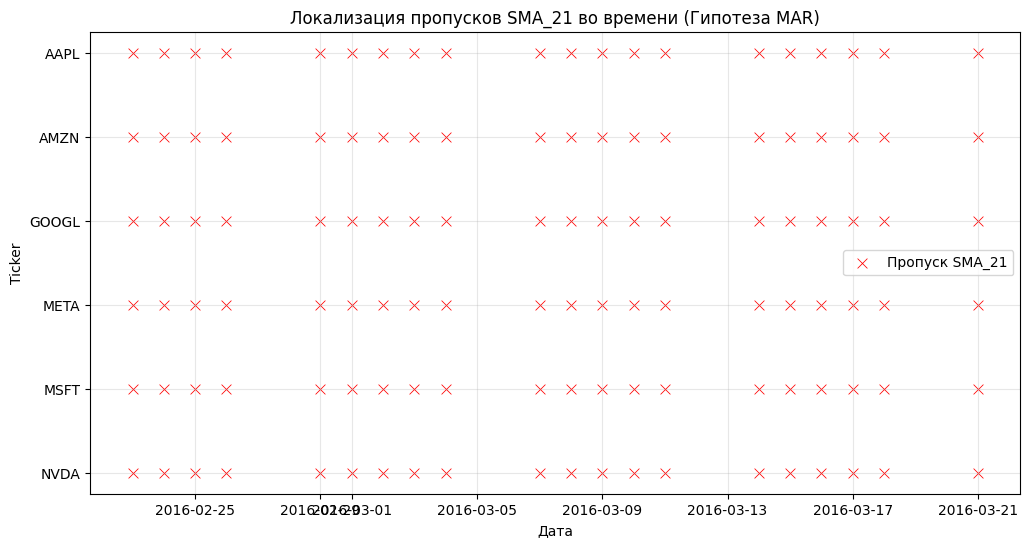

Средний Volume (при пропуске SMA): 106,050,794
Средний Volume (данные есть):      118,726,397
Различие: 10.7%
ВЫВОД: Данные отличаются существенно. Это НЕ случайные пропуски (не MCAR).
Подтверждена гипотеза MAR (пропуски зависят от периода времени).


In [ ]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('../data/faang_stock_prices.csv')
df['Date'] = pd.to_datetime(df['Date'])
print("Данные успешно загружены.")


df_check = df.copy()
df_check['SMA_Simulated'] = df_check.groupby('Ticker')['Close'].transform(
    lambda x: x.rolling(window=21).mean()
)

df_check['Is_Missing'] = df_check['SMA_Simulated'].isna()

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_check[df_check['Is_Missing'] == True], 
    x='Date', 
    y='Ticker', 
    color='red', 
    s=50, 
    marker='x',
    label='Пропуск SMA_21'
)
plt.title('Локализация пропусков SMA_21 во времени (Гипотеза MAR)')
plt.xlabel('Дата')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


vol_missing = df_check[df_check['Is_Missing']]['Volume'].mean()
vol_present = df_check[~df_check['Is_Missing']]['Volume'].mean()

print(f"Средний Volume (при пропуске SMA): {vol_missing:,.0f}")
print(f"Средний Volume (данные есть):      {vol_present:,.0f}")

diff_percent = abs(vol_missing - vol_present) / vol_present * 100
print(f"Различие: {diff_percent:.1f}%")

if diff_percent > 10:
    print("ВЫВОД: Данные отличаются существенно. Это НЕ случайные пропуски (не MCAR).")
    print("Подтверждена гипотеза MAR (пропуски зависят от периода времени).")
else:
    print("ВЫВОД: Различий нет.")

### Задание 3. Индикатор пропуска как источник информации

### 3.1. Когда сам факт пропуска несёт информацию?
Факт пропуска становится информативным признаком, когда природа отсутствия данных не является случайной (ситуация **MNAR** — Missing Not At Random). В этом случае `NaN` — это не «отсутствие информации», а «скрытая категория» или сигнал о специфическом состоянии объекта.

**Пример:** В анкете на кредит поле «Стаж на последнем месте работы» не заполнено. Это, скорее всего, означает не ошибку базы данных, а то, что человек официально безработный. Факт пропуска здесь является сильным предиктором неплатежеспособности.

### 3.2. Почему значимость индикатора в модели — сигнал о плохой импутации?
Если после обучения модели признак `Is_Missing` (индикатор того, что значение было заполнено) получает высокий вес (Feature Importance), это означает следующее:

1.  **Конфликт распределений:** Мы заполнили пропуски каким-то значением (например, средним или медианой), но реальное поведение объектов с пропусками кардинально отличается от поведения «средних» объектов.
2.  **Модель «исправляет» аналитика:** Модель выучила, что *«если стоит флаг импутации, то прогноз нужно скорректировать на +X, так как аналитик заполнил пропуск слишком низким значением»*.

**Вывод:** Если индикатор значим, значит, выбранный метод импутации (заполнения) исказил данные, и модель вынуждена использовать "костыль" в виде индикатора, чтобы различить реальные и выдуманные данные.

### 3.3. Примеры применения индикатора

| Статус | Пример признака | Описание ситуации |
|:---|:---|:---|
| **Полезен** | **Debt_Amount** (Размер долга) | Если поле пустое, это часто значит «Долга нет». Создание индикатора `Has_No_Debt` или заполнение нулем здесь корректно и дает модели мощный сигнал о надежности клиента. |
| **Бесполезен** | **Temperature** (Погода) | Случайный сбой метеодатчика (MCAR). Если 1% данных пропал из-за обрыва связи, факт пропуска никак не поможет предсказать погоду на завтра. Индикатор просто добавит шум в модель. |
| **Опасен** | **Date_of_Churn** (Дата ухода клиента) | **Утечка данных (Data Leakage).** Если мы предсказываем отток клиентов, и у нас есть признак «Дата расторжения договора», то он будет заполнен только у ушедших. Индикатор `Is_Missing` станет идеальным предсказателем (target leakage), давая 100% точность на обучении, но модель будет бесполезна в реальности (т.к. у действующих клиентов дата всегда пуста). |

# 3. Выбросы

## Задание 4. Выброс — это ошибка или сигнал?

**Выбранный признак:** `Volume` (Объем торгов).
**Пример выброса:** Экстремально высокое значение объема (например, превышающее среднее в 5–10 раз), обнаруженное в ходе EDA.

### 4.1. Реальные причины (Природа выброса)
В финансовом датасете такой выброс почти всегда является **сигналом**, а не технической ошибкой. Возможные причины:
1.  **Квартальный отчет (Earnings Call):** Компания опубликовала финансовые результаты, сильно отличающиеся от ожиданий аналитиков. Это вызывает массовую переоценку актива и всплеск сделок.
2.  **Сплит акций (Stock Split):** Если компания провела дробление акций (например, Apple 4-к-1), цена уменьшилась, а количество доступных акций и их ликвидность резко выросли.
3.  **Макроэкономический шок:** Паника на рынке (например, март 2020 года, начало пандемии), когда инвесторы массово распродают активы.

### 4.2. Стратегия работы с выбросом

| Действие | Оценка | Последствия для модели |
|:---|:---|:---|
| **Удалить выброс** | **Худшее решение** | **Потеря критической информации.** Финансовые модели часто строятся именно для того, чтобы предсказывать поведение в кризисные моменты (Risk Management). Удаляя дни с аномальным объемом, мы учим модель работать только на «спокойном» рынке. В реальном кризисе такая модель потерпит крах. |
| **Оставить без изменений** | **Плохо (для линейных моделей)** | **Смещение весов.** Если мы используем линейную регрессию или нейросеть, одно гигантское значение `Volume` (миллиарды) перетянет на себя веса, сделав остальные признаки (цена, RSI) незначимыми. Модель станет нестабильной. |
| **Применить преобразование** | **Лучшее решение** | **Сохранение информации.** Применение логарифмирования (`np.log1p`) или `RobustScaler` сжимает масштаб данных. Аномалия остается «высоким значением», но перестает быть «разрушительным числом» для математики модели. |

**Вывод:** Удаление выбросов в финансовых временных рядах недопустимо, так как «черные лебеди» — это часть рыночной реальности. Необходимо использовать нелинейные преобразования (логарифмирование) для сглаживания их влияния.

# 4. Статистики

## Задание 5. Преобразование или винзоризация?

**Контекст:** Работа с асимметричным признаком, таким как `Volume` (объем торгов) или `Close` (цена), где наблюдается длинный правый хвост распределения.

### 5.1. Критерии выбора метода

| Метод | Когда предпочтительнее? | Применимость к данным FAANG |
|:---|:---|:---|
| **Логарифмирование** ($\log(1+x)$) | **Сильная правосторонняя асимметрия.** <br>Данные различаются на порядки (в 10, 100 раз). Распределение близко к лог-нормальному или степенному закону. | **Идеально для `Volume` и `Close`.** Цены и объемы растут экспоненциально. Логарифм превращает мультипликативные тренды в аддитивные (линейные). |
| **Квадратный корень** ($\sqrt{x}$) | **Умеренная асимметрия.** <br>Данные содержат нули (где логарифм требует сдвига), и разброс значений не превышает 2-3 порядка. Часто используется для счетных данных (распределение Пуассона). | **Менее применимо.** Для финансовых временных рядов логарифм является стандартом де-факто из-за природы сложных процентов. |
| **Винзоризация** (Clipping) | **Наличие изолированных выбросов.** <br>Нужно сохранить исходный масштаб и распределение для 95-99% данных, но «обрезать» экстремальные хвосты, которые ломают модель. | **Для `Daily_Return`.** Можно ограничить доходность (например, диапазоном -10%...+10%), чтобы исключить влияние шоковых дней при обучении модели для спокойного рынка. |

---

### 5.2. Влияние на моделирование и анализ

| Аспект | Логарифмирование | Корень | Винзоризация |
|:---|:---|:---|:---|
| **Интерпретируемость** | **Высокая (Эластичность).** <br>Изменение $X$ интерпретируется в процентах. <br>*Пример:* «Рост объема на 1% увеличивает цену на $\beta$». | **Низкая.** <br>Сложно объяснить бизнесу физический смысл «изменения корня из объема». | **Ясная.** <br>«Все значения выше 100 млн мы считаем равными 100 млн». Масштаб не меняется. |
| **Линейные модели** | **Лучший вариант.** <br>Линеаризует экспоненциальные зависимости и стабилизирует дисперсию (убирает гетероскедастичность). | **Средний эффект.** <br>Снижает влияние хвостов, но хуже справляется с экспоненциальным ростом, чем логарифм. | **Защита от переобучения.** <br>Снижает влияние отдельных точек-выбросов на веса модели, но не исправляет нелинейность данных. |
| **Визуализация** | Превращает скошенное распределение в **симметричное (нормальное)**. Удобно для поиска паттернов. | Сжимает хвост, но распределение часто остается асимметричным. | Сохраняет форму распределения, но создает искусственные **пики на границах** (накопление значений в точках отсечения). |

## Задание 6. Средние, которые вводят в заблуждение

**Выбранный признак:** `Volume` (Объем торгов).

### 6.1. Расчет и сравнение показателей
Для анализа «типичного» дня на бирже были рассчитаны три вида средних:

In [ ]:
import numpy as np

mean_val = df['Volume'].mean()
median_val = df['Volume'].median()

geo_mean_val = np.exp(np.mean(np.log(df['Volume'])))

print(f"Арифметическое среднее: {mean_val:,.0f}")
print(f"Медиана:                {median_val:,.0f}")
print(f"Геометрическое среднее: {geo_mean_val:,.0f}")

Арифметическое среднее: 118,624,748
Медиана:                44,326,000
Геометрическое среднее: 56,836,039


### 6.2. Анализ расхождений

**Почему они различаются?**
Различие обусловлено **правосторонней асимметрией (Right Skew)** распределения объемов.

1.  **Арифметическое среднее** (самое большое) — сильно смещено вверх из-за редких дней с аномально высокими торгами (всплески в 5–10 раз выше нормы).
2.  **Медиана** (самое маленькое) — игнорирует величину этих выбросов, показывая «центр» упорядоченного списка.
3.  **Геометрическое среднее** — находится между ними, так как логарифмирование сглаживает влияние экстремальных значений.

# 5. Визуализация как инструмент мышления

## Задание 7. Неправильная диаграмма

**Цель:** Продемонстрировать, как выбор типа графика может исказить восприятие данных.

### 7.1. Визуальное доказательство (Python)
Мы построим два графика для признака `Volume` (Объем торгов):
1.  **Слева (Плохой выбор):** Столбчатая диаграмма средних (Bar Chart).
2.  **Справа (Правильный выбор):** Ящик с усами (Boxplot).


C:\Users\kurko\AppData\Local\Temp\ipykernel_16764\2456779442.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Ticker', y='Volume', data=df, palette='Set3', errorbar=None)
C:\Users\kurko\AppData\Local\Temp\ipykernel_16764\2456779442.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Ticker', y='Volume', data=df, palette='Set3')


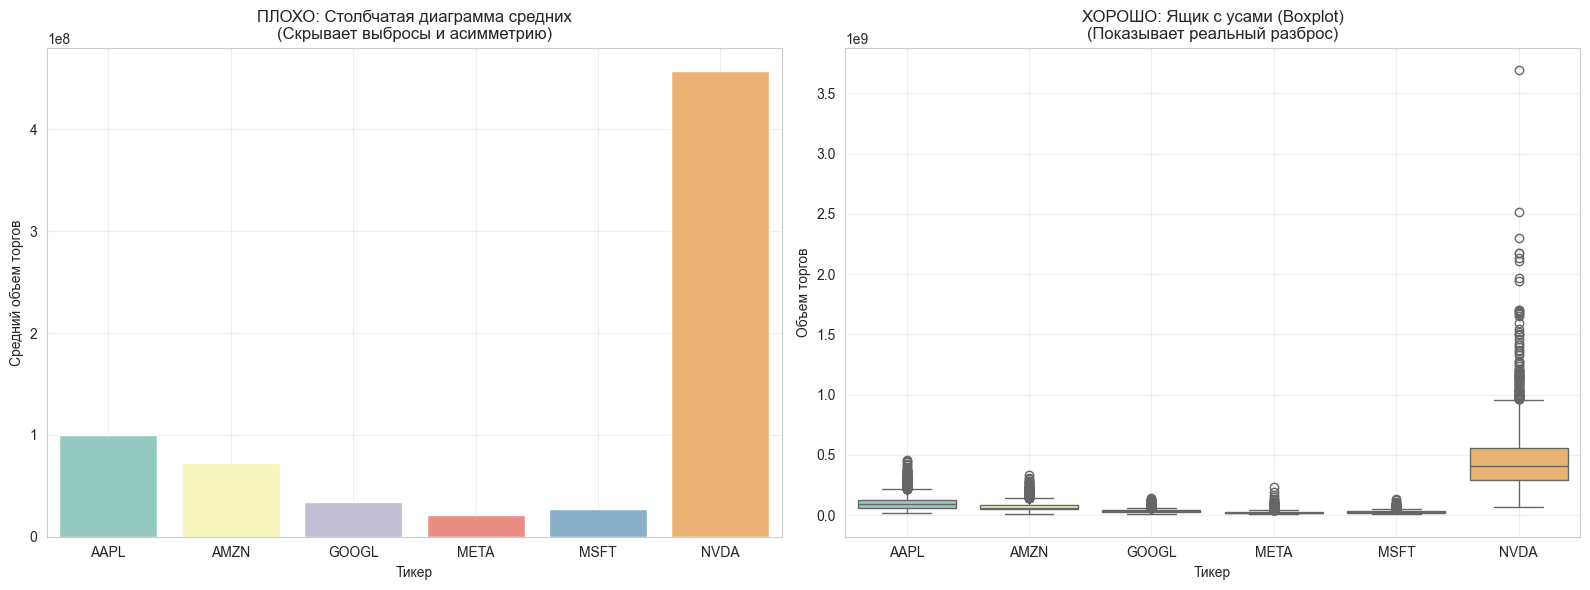

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Ticker', y='Volume', data=df, palette='Set3', errorbar=None)

plt.title('ПЛОХО: Столбчатая диаграмма средних\n(Скрывает выбросы и асимметрию)')
plt.ylabel('Средний объем торгов')
plt.xlabel('Тикер')
plt.grid(True, alpha=0.3)
plt.subplot(1, 2, 2)

sns.boxplot(x='Ticker', y='Volume', data=df, palette='Set3')

plt.title('ХОРОШО: Ящик с усами (Boxplot)\n(Показывает реальный разброс)')
plt.ylabel('Объем торгов')
plt.xlabel('Тикер')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6. Вариативность визуализации

## Задание 8. Одна и та же информация — разные графики

**Выбранная пара признаков:** `Daily_Return` (ось X) и `Volume` (ось Y).
**Задача:** Проанализировать связь между изменением цены и активностью торгов.

### 8.1. Сравнительная визуализация

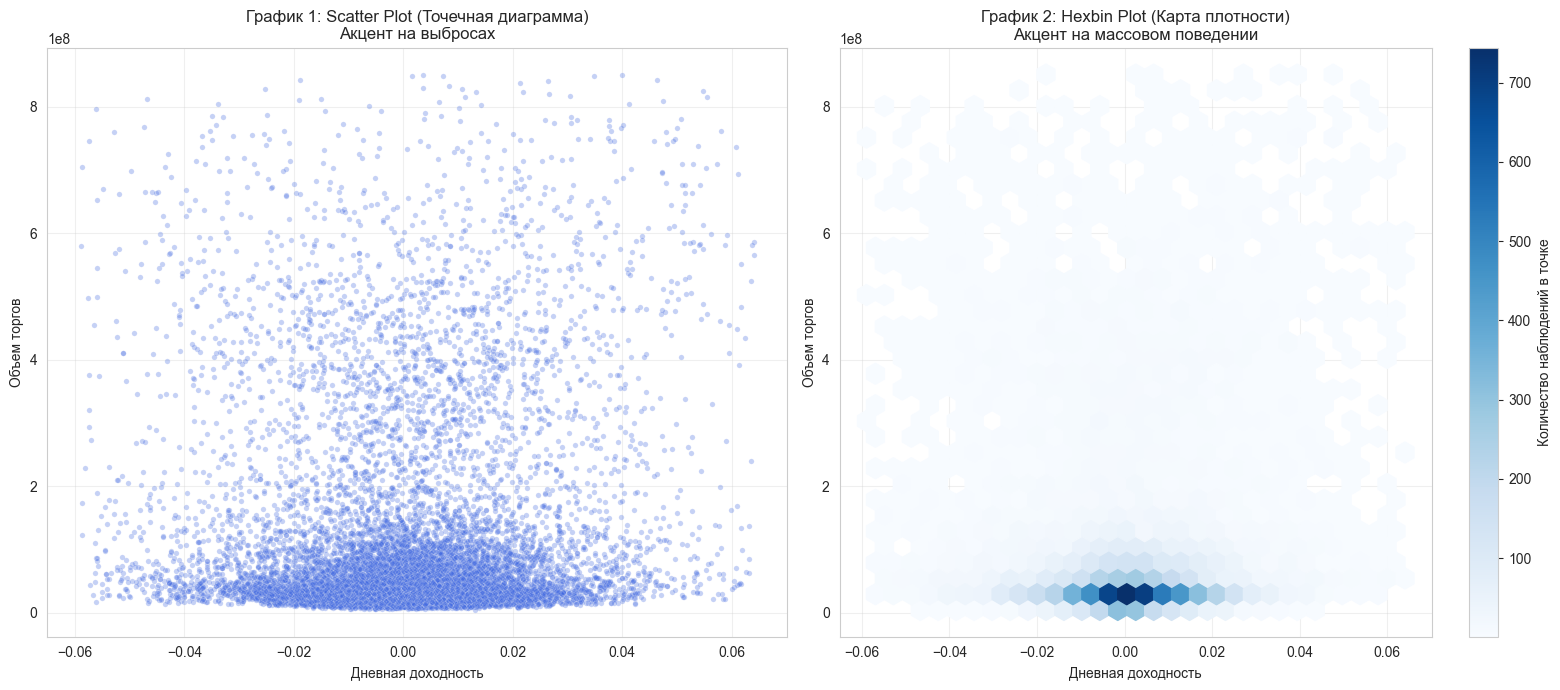

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


mask = (df['Volume'] < df['Volume'].quantile(0.99)) & \
       (df['Daily_Return'].between(df['Daily_Return'].quantile(0.01), df['Daily_Return'].quantile(0.99)))
df_viz = df[mask]

plt.figure(figsize=(16, 7))

# ГРАФИК 1:
plt.subplot(1, 2, 1)
sns.scatterplot(x='Daily_Return', y='Volume', data=df_viz, alpha=0.3, color='royalblue', s=15)
plt.title('График 1: Scatter Plot (Точечная диаграмма)\nАкцент на выбросах', fontsize=12)
plt.xlabel('Дневная доходность')
plt.ylabel('Объем торгов')
plt.grid(True, alpha=0.3)

# ГРАФИК 2
plt.subplot(1, 2, 2)
hb = plt.hexbin(df_viz['Daily_Return'], df_viz['Volume'], gridsize=30, cmap='Blues', mincnt=1)
plt.colorbar(hb, label='Количество наблюдений в точке')
plt.title('График 2: Hexbin Plot (Карта плотности)\nАкцент на массовом поведении', fontsize=12)
plt.xlabel('Дневная доходность')
plt.ylabel('Объем торгов')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 8.2. Анализ различий

Для датасета размером 15 000 строк разница между этими графиками критична:

| Характеристика | **Scatter Plot** (Точечная диаграмма) | **Hexbin Plot** (Шестиугольная карта) |
|:---|:---|:---|
| **Какую информацию подчеркивает?** | **Уникальность и границы.** <br>Отлично показывает «облако» всех возможных состояний рынка и экстремальные точки (выбросы), лежащие далеко от центра. | **Структуру и частоту.** <br>Показывает, где именно рынок проводит 90% времени. Цветом выделяется «ядро» распределения, которое на точечном графике превращается в сплошное синее пятно. |
| **Какие гипотезы легче заметить?** | **Гипотеза о пределах риска:** <br>«Каков максимально возможный объем торгов при падении цены на 5%?». <br>Здесь легко увидеть крайние точки. | **Гипотеза о нормальности:** <br>«Правда ли, что в большинстве случаев торги проходят на низких объемах с доходностью около 0%?». <br>Градиент цвета четко показывает концентрацию в центре. |
| **Слабые стороны** | **Overplotting (Перекрытие).** <br>В центре графика тысячи точек накладываются друг на друга, создавая «черную дыру». Невозможно понять, там 100 точек или 10 000. | **Скрытие выбросов.** <br>Одиночные редкие события могут стать бледными и незаметными на фоне яркого центрального ядра. |